### 패키지 가져오기

In [ ]:
!pip install pykrx -q
!pip install finance-datareader -q

In [ ]:
from pykrx import stock
from pykrx import bond

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import FinanceDataReader as fdr

import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
start_date, end_date = "2010-01-01", "2023-01-31"
kospi_tickers = stock.get_market_ticker_list(end_date, market='KOSPI')
kosdaq_tickers = stock.get_market_ticker_list(end_date, market='KOSDAQ')
all_tickers = kospi_tickers + kosdaq_tickers

print("KOSPI 종목 수: ", len(kospi_tickers))
print("KOSDAQ 종목 수: ", len(kosdaq_tickers))
print("전체 종목 수: ", len(all_tickers))

KOSPI 종목 수:  943
KOSDAQ 종목 수:  1615
전체 종목 수:  2558


### 성장주 포트폴리오 가치주 포트폴리오 나누기

In [ ]:
set_date = "20210104"

# 코스피 코스닥 종목의 PER, PBR 구함
kospi_pbr_df = stock.get_market_fundamental(set_date, market='KOSPI')[['PBR', 'PER']]
kosdaq_pbr_df = stock.get_market_fundamental(set_date, market='KOSDAQ')[['PBR', 'PER']]
pbr_df = pd.concat([kospi_pbr_df, kosdaq_pbr_df], axis=0)
# 코스피 코스닥 종목의 거래대금 구함
kospi_volume_df = stock.get_market_cap(set_date, market='KOSPI')['거래대금']
kosdaq_volume_df = stock.get_market_cap(set_date, market='KOSDAQ')['거래대금']
volume_df = pd.concat([kospi_volume_df, kosdaq_volume_df], axis=0)

# 합치고, 결측치를 처리해줌
df = pd.concat([pbr_df, volume_df], axis=1)
df['PBR'] = df['PBR'].fillna(0)
df['PER'] = df['PER'].fillna(-1)

In [ ]:
q1, q4 = df['PBR'].quantile(0.2), df['PBR'].quantile(0.8) 
growth_market = df[(df['PBR'] >= q4) & (df['PER'] > 0) & (df['거래대금']>0)]
value_market = df[(df['PBR'] <= q1) & (df['PER'] > 0) & (df['거래대금']>0)]

### 전략1 2021년에 성장주를 사서 holding

In [ ]:
# equal weight
growth_market = growth_market.sort_values(by='PBR', ascending= False)
growth_market['weight'] = 1/len(growth_market)
growth_market.head()

,PBR,PER,거래대금,weight
티커,,,,
019170,32.26,3485.71,171753891000,0.003774
096530,31.61,179.14,122990073800,0.003774
139670,30.85,5720.00,14726752700,0.003774
068760,28.45,925.00,380197854900,0.003774
299030,25.87,69.33,337399907500,0.003774


In [ ]:
# PBR에 비례해서
growth_market['weight'] = growth_market['PBR'] / growth_market['PBR'].sum()
growth_market

,PBR,PER,거래대금,weight
티커,,,,
019170,32.26,3485.71,171753891000,0.017922
096530,31.61,179.14,122990073800,0.017561
139670,30.85,5720.00,14726752700,0.017139
068760,28.45,925.00,380197854900,0.015805
299030,25.87,69.33,337399907500,0.014372
...,...,...,...,...
005250,3.27,908.47,837923688100,0.001817
263770,3.27,59.17,12788627820,0.001817
256150,3.26,15.77,1083267700,0.001811


In [ ]:
price_dict = {}
for ticker in tqdm(growth_market.index):
  df = fdr.DataReader(ticker, set_date, end_date)
  close_price = df['Close']
  price_dict[ticker] = close_price
  time.sleep(0.01)
df = pd.DataFrame(price_dict)

100%|██████████| 265/265 [05:34<00:00,  1.26s/it]


In [ ]:
df = df.resample("M").last()
return_df = df.pct_change().shift(-1)
return_df.head()

,019170,096530,139670,068760,299030,352820,336260,101360,048410,009900,...,290550,002960,192650,097520,084370,005250,263770,256150,234100,004770
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-31,0.034568,-0.245457,1.291667,-0.121718,-0.077967,0.009780,-0.102334,-0.184516,1.404396,-0.121469,...,-0.226824,0.020450,-0.106667,0.044146,0.091031,-0.156818,-0.057143,0.057354,0.173931,-0.114464
2021-02-28,0.015513,0.044990,-0.054545,-0.024073,0.089923,0.176755,0.026000,-0.041139,-0.212980,-0.180064,...,-0.035714,0.010020,0.008529,0.020221,0.093252,-0.060647,0.248485,0.116950,0.053765,-0.189189
2021-03-31,-0.179788,0.431543,0.038462,-0.113334,0.174603,0.010101,-0.120858,0.100660,-0.034843,0.174510,...,0.092593,0.057540,0.035941,-0.136937,0.077441,0.050215,0.181230,0.224688,-0.103540,0.034783
2021-04-30,-0.073066,-0.276709,-0.629630,0.047374,-0.103604,0.090535,-0.025499,-0.134933,-0.116727,-0.128548,...,-0.024213,0.016886,0.102041,0.013570,-0.031250,-0.064208,-0.123288,-0.173267,-0.029292,-0.002801
2021-05-31,0.329212,0.221566,-0.087500,0.128498,0.063652,0.103774,0.137656,-0.005199,-0.012262,0.088123,...,0.094293,0.059041,0.101852,-0.023687,-0.025806,-0.004380,0.051562,-0.059880,0.046218,0.036517


In [ ]:
return_df = pd.DataFrame(np.array(return_df) @ np.array(growth_market['weight']), columns=['Return'], index=return_df.index)
return_df.head()

,Return
Date,
2021-01-31,0.003042
2021-02-28,0.022982
2021-03-31,0.038623
2021-04-30,-0.034602
2021-05-31,0.053891


In [ ]:
cumulative_return = np.exp(np.log(return_df + 1).cumsum())-1
cumulative_return.columns = ['Cumulative Return'] 
cumulative_return.head()

,Cumulative Return
Date,
2021-01-31,0.003042
2021-02-28,0.026093
2021-03-31,0.065724
2021-04-30,0.028848
2021-05-31,0.084294


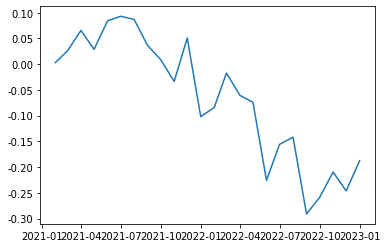

In [ ]:
plt.plot(cumulative_return)

### 전략2 2021년에 가치주를 사서 holding

In [ ]:
# equal weight
value_market = value_market.sort_values(by='PBR', ascending= True)
value_market['weight'] = 1/len(value_market)
value_market.head()

,PBR,PER,거래대금,weight
티커,,,,
192410,0.14,3.40,422948405,0.00578
058650,0.16,9.99,25528400,0.00578
088350,0.16,130.00,20318418600,0.00578
012320,0.18,7.74,91140150,0.00578
001430,0.21,22.36,2812329900,0.00578


In [ ]:
# PBR의 역수에 비례해서
value_market['weight'] = (1/value_market['PBR']) / ((1/value_market['PBR']).sum())
value_market

,PBR,PER,거래대금,weight
티커,,,,
192410,0.14,3.40,422948405,0.014786
058650,0.16,9.99,25528400,0.012937
088350,0.16,130.00,20318418600,0.012937
012320,0.18,7.74,91140150,0.011500
001430,0.21,22.36,2812329900,0.009857
...,...,...,...,...
072870,0.51,10.66,1236989900,0.004059
005830,0.51,7.17,13462310950,0.004059
011370,0.51,15.71,2271304620,0.004059


In [ ]:
price_dict = {}
for ticker in tqdm(value_market.index):
  df = fdr.DataReader(ticker, set_date, end_date)
  close_price = df['Close']
  price_dict[ticker] = close_price
  time.sleep(0.01)
df = pd.DataFrame(price_dict)
df = df.resample("M").last()
return_df = df.pct_change().shift(-1)
return_df = pd.DataFrame(np.array(return_df) @ np.array(value_market['weight']), columns=['Return'], index=return_df.index)
return_df.head()

100%|██████████| 173/173 [04:07<00:00,  1.43s/it]


,Return
Date,
2021-01-31,0.061893
2021-02-28,0.126729
2021-03-31,0.108468
2021-04-30,0.065591
2021-05-31,0.037182


In [ ]:
cumulative_return = np.exp(np.log(return_df + 1).cumsum())-1
cumulative_return.columns = ['Cumulative Return'] 
cumulative_return.head()

,Cumulative Return
Date,
2021-01-31,0.061893
2021-02-28,0.196465
2021-03-31,0.326243
2021-04-30,0.413233
2021-05-31,0.465779


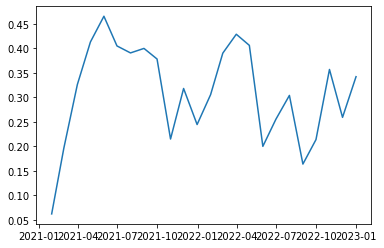

In [ ]:
plt.plot(cumulative_return)

### 분기마다 리밸런싱을 실행 (가치주)

2015년부터 비중 및 종목을 분기마다 바꾸고 수익률을 계산

In [ ]:
# 월의 첫 영업일을 찾는 함수
def get_first_work_day(year, month):
  for i in range(1, 31):
    temp = str(year).zfill(4) + str(month).zfill(2) + str(i).zfill(2)
    if stock.get_nearest_business_day_in_a_week(temp) == temp:
      temp = temp[:4] + "-" + temp[4:6] + "-" + temp[6:]
      return temp

In [ ]:
# 분기의 첫 영업일을 찾아줌
rebalance_date = ['2015-01-02', '2015-04-01', '2015-07-01', '2015-10-01',
                  '2016-01-04', '2016-04-01','2016-07-01', '2016-10-04',
                  '2017-01-02', '2017-04-03', '2017-07-03', '2017-10-10',
                  '2018-01-02', '2018-04-02', '2018-07-02', '2018-10-01',
                  '2019-01-02', '2019-04-01', '2019-07-01', '2019-10-01',
                  '2020-01-02', '2020-04-01', '2020-07-01', '2020-10-05',
                  '2021-01-04', '2021-04-01', '2021-07-01', '2021-10-01',
                  '2022-01-03', '2022-04-01', '2022-07-01', '2022-10-04',
                  '2023-01-02', '2023-01-31']

In [ ]:
# 쓰이는 모든 티커들을 모음
all_tickers = []
for date in rebalance_date:
  kospi_tickers = stock.get_market_ticker_list(date, market='KOSPI')
  kosdaq_tickers = stock.get_market_ticker_list(date, market='KOSDAQ')
  all_tickers += kospi_tickers
  all_tickers += kosdaq_tickers
all_tickers = list(set(all_tickers))

In [ ]:
# 시작하는 날부터 끝날까지 모든 티커의 종가를 가져옴
price_dict = {}
for ticker in tqdm(all_tickers):
  price_df = fdr.DataReader(ticker, rebalance_date[0], rebalance_date[-1])
  close_price = price_df['Close']
  price_dict[ticker] = close_price
  time.sleep(0.01)
price_df = pd.DataFrame(price_dict)
price_df.to_csv('price_df.csv')

100%|██████████| 2863/2863 [1:01:03<00:00,  1.28s/it]


In [ ]:
price_df = pd.read_csv('price_df.csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

,079960,072130,373340,217730,005490,109960,330730,083650,279410,252990,...,042520,027970,012750,049180,017810,086060,000100,265560,001525,334970
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,11750,4790,0.0,0.0,283500,391,0.0,5736,0.0,0.0,...,16250,1785,71100,7635,11200,2945,24897,0.0,3090,0.0
2015-01-05,11750,4645,0.0,0.0,279000,391,0.0,5636,0.0,0.0,...,16550,1780,72100,7578,11300,2990,24750,0.0,3090,0.0
2015-01-06,11250,4395,0.0,0.0,275000,397,0.0,5661,0.0,0.0,...,16150,1751,70100,7750,11000,3100,24602,0.0,3080,0.0
2015-01-07,11400,4530,0.0,0.0,279500,378,0.0,5611,0.0,0.0,...,15950,1756,69300,7764,10850,2955,24382,0.0,3075,0.0
2015-01-08,11700,4480,0.0,0.0,286000,377,0.0,5535,0.0,0.0,...,16250,1814,69200,8151,10850,2870,24161,0.0,3075,0.0


In [ ]:
total_return_df = pd.DataFrame()

for i in tqdm(range(len(rebalance_date)-1)):
  set_date = rebalance_date[i]
  end_date = rebalance_date[i+1]
  # 코스피 코스닥 종목의 PER, PBR 구함
  kospi_pbr_df = stock.get_market_fundamental(set_date, market='KOSPI')[['PBR', 'PER']]
  kosdaq_pbr_df = stock.get_market_fundamental(set_date, market='KOSDAQ')[['PBR', 'PER']]
  pbr_df = pd.concat([kospi_pbr_df, kosdaq_pbr_df], axis=0)

  # 코스피 코스닥 종목의 거래대금 구함
  kospi_volume_df = stock.get_market_cap(set_date, market='KOSPI')['거래대금']
  kosdaq_volume_df = stock.get_market_cap(set_date, market='KOSDAQ')['거래대금']
  volume_df = pd.concat([kospi_volume_df, kosdaq_volume_df], axis=0)

  # 합치고, 결측치를 처리해줌
  df = pd.concat([pbr_df, volume_df], axis=1)
  df['PBR'] = df['PBR'].fillna(0)
  df['PER'] = df['PER'].fillna(-1)

  # 가치주 포트폴리오와 성장주 포트폴리오
  q1, q4 = df['PBR'].quantile(0.2), df['PBR'].quantile(0.8) 
  growth_market = df[(df['PBR'] >= q4) & (df['PER'] > 0) & (df['거래대금']>0)]
  value_market = df[(df['PBR'] <= q1) & (df['PER'] > 0) & (df['거래대금']>0)]

  # PBR의 역수에 비례해서 자산을 배분
  value_market['weight'] = (1/value_market['PBR']) / ((1/value_market['PBR']).sum())

  # 가치주에 들어있는 종목들의 가격을 가져옴
  ####  loc를 이용해 필요한 부분만 빼오는 것으로 코드를 수정
  price_dict = {}
  for ticker in value_market.index:
    df = price_df.loc[set_date:end_date, ticker]
    price_dict[ticker] = df
  df = pd.DataFrame(price_dict)
  
  # 해당종목들의 월별 수익률을 계산
  return_df = df.pct_change().shift(-1)
  return_df = pd.DataFrame(np.array(return_df) @ np.array(value_market['weight']), columns=['Return'], index=return_df.index)
  return_df = return_df.dropna()

  total_return_df = pd.concat([total_return_df, return_df], axis=0)

100%|██████████| 33/33 [01:23<00:00,  2.52s/it]


In [ ]:
cumulative_return = (1+total_return_df).cumprod()-1
cumulative_return.columns = ['Cumulative Return'] 
cumulative_return.index= pd.to_datetime(cumulative_return.index)
cumulative_return.head()

,Cumulative Return
Date,
2015-01-02,0.000914
2015-01-05,-0.007564
2015-01-06,-0.009455
2015-01-07,-0.007812
2015-01-08,-0.002754


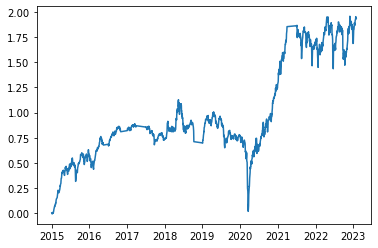

In [ ]:
plt.plot(cumulative_return)

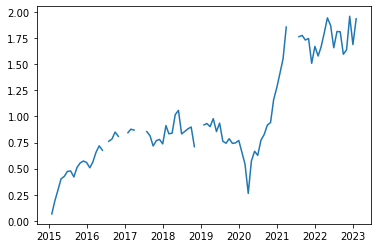

In [ ]:
monthly_cumulative_return = cumulative_return.resample("M").last()
plt.plot(monthly_cumulative_return)

### 분기마다 리밸런싱을 실행 (성장주)

2015년부터 비중 및 종목을 분기마다 바꾸고 수익률을 계산

In [ ]:
price_df = pd.read_csv('price_df.csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

,079960,072130,373340,217730,005490,109960,330730,083650,279410,252990,...,042520,027970,012750,049180,017810,086060,000100,265560,001525,334970
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,11750,4790,0.0,0.0,283500,391,0.0,5736,0.0,0.0,...,16250,1785,71100,7635,11200,2945,24897,0.0,3090,0.0
2015-01-05,11750,4645,0.0,0.0,279000,391,0.0,5636,0.0,0.0,...,16550,1780,72100,7578,11300,2990,24750,0.0,3090,0.0
2015-01-06,11250,4395,0.0,0.0,275000,397,0.0,5661,0.0,0.0,...,16150,1751,70100,7750,11000,3100,24602,0.0,3080,0.0
2015-01-07,11400,4530,0.0,0.0,279500,378,0.0,5611,0.0,0.0,...,15950,1756,69300,7764,10850,2955,24382,0.0,3075,0.0
2015-01-08,11700,4480,0.0,0.0,286000,377,0.0,5535,0.0,0.0,...,16250,1814,69200,8151,10850,2870,24161,0.0,3075,0.0


In [ ]:
total_return_df = pd.DataFrame()

for i in tqdm(range(len(rebalance_date)-1)):
  set_date = rebalance_date[i]
  end_date = rebalance_date[i+1]
  # 코스피 코스닥 종목의 PER, PBR 구함
  kospi_pbr_df = stock.get_market_fundamental(set_date, market='KOSPI')[['PBR', 'PER']]
  kosdaq_pbr_df = stock.get_market_fundamental(set_date, market='KOSDAQ')[['PBR', 'PER']]
  pbr_df = pd.concat([kospi_pbr_df, kosdaq_pbr_df], axis=0)

  # 코스피 코스닥 종목의 거래대금 구함
  kospi_volume_df = stock.get_market_cap(set_date, market='KOSPI')['거래대금']
  kosdaq_volume_df = stock.get_market_cap(set_date, market='KOSDAQ')['거래대금']
  volume_df = pd.concat([kospi_volume_df, kosdaq_volume_df], axis=0)

  # 합치고, 결측치를 처리해줌
  df = pd.concat([pbr_df, volume_df], axis=1)
  df['PBR'] = df['PBR'].fillna(0)
  df['PER'] = df['PER'].fillna(-1)

  # 가치주 포트폴리오와 성장주 포트폴리오
  q1, q4 = df['PBR'].quantile(0.2), df['PBR'].quantile(0.8) 
  growth_market = df[(df['PBR'] >= q4) & (df['PER'] > 0) & (df['거래대금']>0)]
  value_market = df[(df['PBR'] <= q1) & (df['PER'] > 0) & (df['거래대금']>0)]

  # PBR의 역수에 비례해서 자산을 배분
  growth_market['weight'] = growth_market['PBR'] / growth_market['PBR'].sum()

  # 성장주에 들어있는 종목들의 가격을 가져옴
  ####  loc를 이용해 필요한 부분만 빼오는 것으로 코드를 수정
  price_dict = {}
  for ticker in growth_market.index:
    df = price_df.loc[set_date:end_date, ticker]
    price_dict[ticker] = df
  df = pd.DataFrame(price_dict)
  
  # 해당종목들의 월별 수익률을 계산
  return_df = df.pct_change().shift(-1)
  return_df = pd.DataFrame(np.array(return_df) @ np.array(growth_market['weight']), columns=['Return'], index=return_df.index)
  return_df = return_df.dropna()

  total_return_df = pd.concat([total_return_df, return_df], axis=0)

100%|██████████| 33/33 [01:25<00:00,  2.58s/it]


In [ ]:
cumulative_return = np.exp(np.log(1+total_return_df).cumsum())-1
cumulative_return.columns = ['Cumulative Return'] 
cumulative_return.index= pd.to_datetime(cumulative_return.index)
cumulative_return.head()

,Cumulative Return
Date,
2015-01-02,0.017037
2015-01-05,0.012337
2015-01-06,0.017509
2015-01-07,0.032201
2015-01-08,0.046968


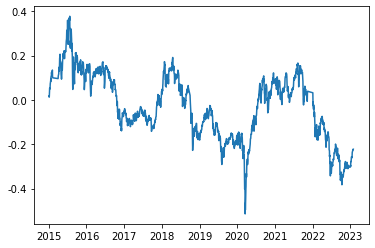

In [ ]:
plt.plot(cumulative_return)